In [1]:
# import libraries for working with .nc
import xarray as xr
import os   
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd



In [2]:
# load 'CHL_mean_smoothed.nc'
chl_mean = xr.open_dataset('CHL_mean_smoothed.nc')

chl_mean



<xarray.Dataset>
Dimensions:    (latitude: 1248, longitude: 1056, doy: 246)
Coordinates:
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
  * doy        (doy) int64 60 61 62 63 64 65 66 ... 299 300 301 302 303 304 305
Data variables:
    CHL        (doy, latitude, longitude) float32 ...

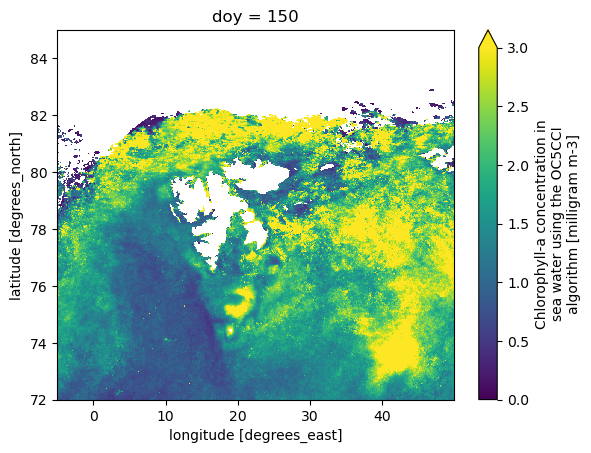

In [3]:
# plot doy 233 CHL scale 0-3
chl_mean.sel(doy=150)['CHL'].plot(vmin=0, vmax=3)



# Metriche fenologiche

In [4]:
chl_mean

<xarray.Dataset>
Dimensions:    (latitude: 1248, longitude: 1056, doy: 246)
Coordinates:
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
  * doy        (doy) int64 60 61 62 63 64 65 66 ... 299 300 301 302 303 304 305
Data variables:
    CHL        (doy, latitude, longitude) float32 ...

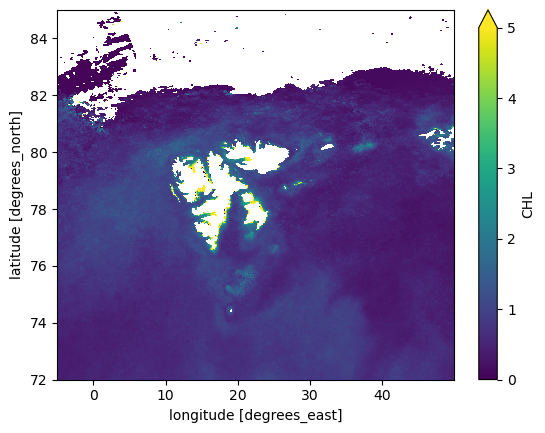

In [17]:
threshold = chl_mean.median(dim="doy") * 1.05
# plot threshold
threshold['CHL'].plot(vmin=0, vmax=5)

In [19]:
over_threshold = chl_mean > threshold
over_threshold

<xarray.Dataset>
Dimensions:    (latitude: 1248, longitude: 1056, doy: 246)
Coordinates:
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
  * doy        (doy) int64 60 61 62 63 64 65 66 ... 299 300 301 302 303 304 305
Data variables:
    CHL        (doy, latitude, longitude) bool False False False ... False False

In [20]:
    # Differentiate to find start and end of blooms
differentiated = over_threshold.astype(int).diff(dim="doy")
bloom_starts = (differentiated == 1)
bloom_ends = (differentiated == -1)

In [21]:
differentiated

<xarray.Dataset>
Dimensions:    (doy: 245, latitude: 1248, longitude: 1056)
Coordinates:
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
  * doy        (doy) int64 61 62 63 64 65 66 67 ... 299 300 301 302 303 304 305
Data variables:
    CHL        (doy, latitude, longitude) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

In [23]:
# Calculate duration of each bloom
bloom_durations = (bloom_ends * 0).cumsum(dim="doy") - (bloom_starts * 0).cumsum(dim="doy") + bloom_starts
bloom_durations

<xarray.Dataset>
Dimensions:    (latitude: 1248, longitude: 1056, doy: 245)
Coordinates:
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
  * doy        (doy) int64 61 62 63 64 65 66 67 ... 299 300 301 302 303 304 305
Data variables:
    CHL        (doy, latitude, longitude) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

In [31]:
# max of bloom_durations (estraendo i valori)
max_bloom_durations = bloom_durations.max(dim="doy")
max_bloom_durations

<xarray.Dataset>
Dimensions:    (latitude: 1248, longitude: 1056)
Coordinates:
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
Data variables:
    CHL        (latitude, longitude) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1

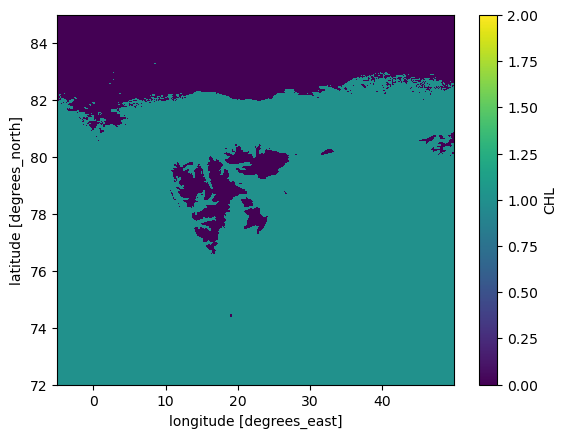

In [35]:
# plot max_bloom_durations
max_bloom_durations['CHL'].plot(vmin=0, vmax=2)

In [27]:
# Identify valid blooms
valid_blooms = bloom_durations.where(bloom_durations >= 14).notnull()
valid_blooms


<xarray.Dataset>
Dimensions:    (doy: 245, latitude: 1248, longitude: 1056)
Coordinates:
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
  * doy        (doy) int64 61 62 63 64 65 66 67 ... 299 300 301 302 303 304 305
Data variables:
    CHL        (doy, latitude, longitude) bool False False False ... False False

In [ ]:
# Count valid blooms
bfreq = valid_blooms.sum(dim="doy")
bfreq

In [5]:
from scipy.integrate import simps

def calculate_metrics(da):
    # Calculate threshold
    threshold = da.median(dim="doy") * 1.05
    over_threshold = da > threshold
    
    # Differentiate to find start and end of blooms
    differentiated = over_threshold.astype(int).diff(dim="doy")
    bloom_starts = (differentiated == 1)
    bloom_ends = (differentiated == -1)
    
    # Calculate duration of each bloom
    bloom_durations = (bloom_ends * 0).cumsum(dim="doy") - (bloom_starts * 0).cumsum(dim="doy") + bloom_starts
    
    # Identify valid blooms
    valid_blooms = bloom_durations.where(bloom_durations >= 14).notnull()
    
    # Count valid blooms
    bfreq = valid_blooms.sum(dim="doy")
    
    # Identify peaks for valid blooms
    if valid_blooms.any(): # Check if there are any valid blooms
      peaks = da.where(valid_blooms).groupby('doy').max(dim="doy")
      max_chl = peaks.max()
    else:
        peaks = xr.DataArray(np.nan, coords=da.coords) # Creating a placeholder DataArray filled with NaN values
        max_chl = np.nan
    
    # BPeak, BInit, BTerm
    valid_peak_values = peaks.where(peaks == max_chl, drop=True).doy.values
    bpeak = valid_peak_values[0] if valid_peak_values.size > 0 else np.nan
    binit = da.where(valid_blooms).doy.min().values if valid_blooms.any() else np.nan
    bterm = da.where(valid_blooms).doy.max().values if valid_blooms.any() else np.nan
    
    # BDur, BArea
    bdur = (bterm - binit + 1) if (binit is not np.nan and bterm is not np.nan) else np.nan
    barea = xr.apply_ufunc(simps, da.where(valid_blooms), input_core_dims=[["doy"]], kwargs={"x": da.doy}, vectorize=True) if valid_blooms.any() else np.nan
    
    # YArea
    yarea = xr.apply_ufunc(simps, da, input_core_dims=[["doy"]], kwargs={"x": da.doy}, vectorize=True)
    
    # BAmp
    bamp = max_chl - da.mean(dim="doy")
    
    # Bdiff, BPeakdiff
    flattened_peaks = peaks.values.flatten()
    sorted_peaks_values = np.sort(flattened_peaks)[::-1]  # Descending order
    
    max_peak = sorted_peaks_values[0]
    second_max_peak = sorted_peaks_values[1] if len(sorted_peaks_values) > 1 else np.nan

    if len(sorted_peaks_values) > 1:
        bdiff = max_peak - second_max_peak
        bpeakdiff = np.nan  # For now, we'll leave this as NaN due to challenges with the numpy array.
    else:
        bdiff = np.nan
        bpeakdiff = np.nan
    
    metrics = {
        'Mean': da.mean(dim="doy"),
        'Max': max_chl,
        'BAmp': bamp,
        'BPeak': bpeak,
        'BInit': binit,
        'BTerm': bterm,
        'BDur': bdur,
        'BArea': barea,
        'YArea': yarea,
        'BFreq': bfreq,
        'Bdiff': bdiff,
        'BPeakdiff': bpeakdiff
    }
    
    return metrics

# Assuming chl_mean is your Dataset
ds = chl_mean.copy()
metrics = calculate_metrics(ds.CHL)
for metric_name, calculation in metrics.items():
    ds[metric_name] = calculation

print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 1248, longitude: 1056, doy: 246)
Coordinates:
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
  * doy        (doy) int64 60 61 62 63 64 65 66 ... 299 300 301 302 303 304 305
Data variables: (12/13)
    CHL        (doy, latitude, longitude) float32 nan nan nan ... nan nan nan
    Mean       (latitude, longitude) float32 nan nan nan ... 0.6647 0.68 0.6806
    Max        float64 nan
    BAmp       (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    BPeak      float64 nan
    BInit      float64 nan
    ...         ...
    BDur       float64 nan
    BArea      float64 nan
    YArea      (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
    BFreq      (latitude, longitude) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    Bdiff      float64 nan
    BPeakdiff  float64 nan


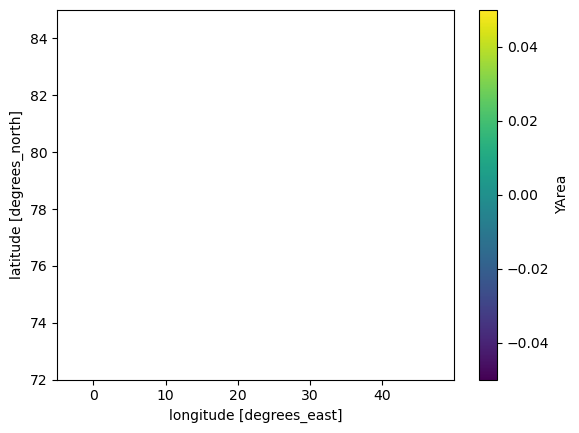

In [10]:
# plotta BFreq
ds['YArea'].plot()